In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

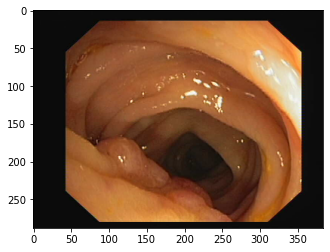

In [7]:
img_bgr = cv2.imread('./images/1.bmp')
img_hsv = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2HSV)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [9]:
L, S = robust_pca(img_rgb)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [3]:
import math
import numpy.linalg

def robust_pca(M):
    """ 
    Decompose a matrix into low rank and sparse components.
    Computes the RPCA decomposition using Alternating Lagrangian Multipliers.
    Returns L,S the low rank and sparse components respectively
    """
    L = numpy.zeros(M.shape)
    S = numpy.zeros(M.shape)
    Y = numpy.zeros(M.shape)
    mu = (M.shape[0] * M.shape[1]) / (4.0 * L1Norm(M))
    lamb = max(M.shape) ** -0.5
    while not converged(M,L,S):
        L = svd_shrink(M - S - (mu**-1) * Y, mu)
        S = shrink(M - L + (mu**-1) * Y, lamb * mu)
        Y = Y + mu * (M - L - S)
    return L,S
    
def svd_shrink(X, tau):
    """
    Apply the shrinkage operator to the singular values obtained from the SVD of X.
    The parameter tau is used as the scaling parameter to the shrink function.
    Returns the matrix obtained by computing U * shrink(s) * V where 
        U are the left singular vectors of X
        V are the right singular vectors of X
        s are the singular values as a diagonal matrix
    """
    U,s,V = numpy.linalg.svd(X, full_matrices=False)
    return numpy.dot(U, numpy.dot(numpy.diag(shrink(s, tau)), V))
    
def shrink(X, tau):
    """
    Apply the shrinkage operator the the elements of X.
    Returns V such that V[i,j] = max(abs(X[i,j]) - tau,0).
    """
    V = numpy.copy(X).reshape(X.size)
    for i in xrange(V.size):
        V[i] = math.copysign(max(abs(V[i]) - tau, 0), V[i])
        if V[i] == -0:
            V[i] = 0
    return V.reshape(X.shape)
            
def frobeniusNorm(X):
    """
    Evaluate the Frobenius norm of X
    Returns sqrt(sum_i sum_j X[i,j] ^ 2)
    """
    accum = 0
    V = numpy.reshape(X,X.size)
    for i in xrange(V.size):
        accum += abs(V[i] ** 2)
    return math.sqrt(accum)

def L1Norm(X):
    """
    Evaluate the L1 norm of X
    Returns the max over the sum of each column of X
    """
    return max(numpy.sum(X,axis=0))

def converged(M,L,S):
    """
    A simple test of convergence based on accuracy of matrix reconstruction
    from sparse and low rank parts
    """
    error = frobeniusNorm(M - L - S) / frobeniusNorm(M)
    return error <= 10e-6